<a href="https://colab.research.google.com/github/srinathchowdary11/Advanced-Machine-Learning/blob/main/Assignment-3/Assignment_3_AML_TIME_SERIES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment-3**  **RNN WEATHER TIME SERIES FORCASTING**

Installing Tenserflow 2.12

In [ ]:
!pip install tensorflow==2.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 41.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninst

A temperature-forecasting example- Data Upload from mazon Web Services (AWS) /keras



In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-05 05:17:33--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.202.40, 54.231.130.144, 52.216.50.144, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.202.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  17.1MB/s    in 0.8s    

2024-04-05 05:17:34 (17.1 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Inspecting the data of the Jena weather dataset which has - 420451 rows and 15 Features

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

num_variables = len(header)
print("Number of variables:", num_variables)
num_rows = len(lines)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


Parsing the data- converting the comma-separated values into floating-point numbers, and then storing specific values in the temperature and raw_data arrays for further processing or analysis.

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

Plotting the temperature timeseries

Text(0, 0.5, 'Temperature')

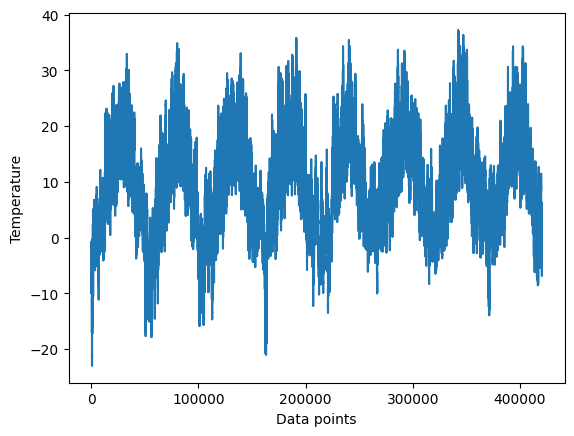

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.xlabel('Data points')
plt.ylabel('Temperature')

Plotting the first 10 days of the temperature timeseries- As given that one day data has 144 data points hence 10days will have 1440 data points

Text(0, 0.5, 'Temperature')

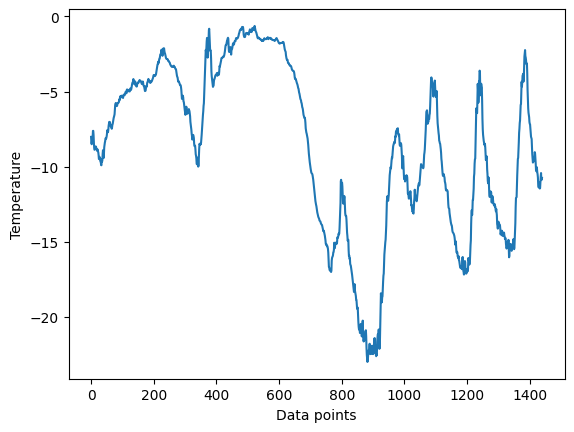

In [ ]:
plt.plot(range(1440), temperature[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

Computing the number of samples we'll use for each data split- 50% for Train, 25%- validation

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


**Preparing the data**

Normalizing the data- Since the data is already in a numerical format, vectorization is unnecessary. However, given that the data scales differ across variables, with temperature ranging from -20 to +30 and pressure measured in millibars, it is advisable to standardize all variables.

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


Instantiating datasets for training, validation, and testing - it is required because the samples in the dataset are highly redundant Hence, it would be inefficient to allocate memory for each sample explicitly. Instead, we will generate the samples dynamically.

Inspecting the output of one of our datasets

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


**A common-sense, non-machine-learning baseline**

Computing the common-sense baseline MAE - This defined function "evaluate_naive_method" provides a baseline for evaluating the performance of a simple forecasting approach, where the last value in the input sequence is used as a prediction for the next value.

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Utilizing a basic baseline methodology, wherein it is presumed that the temperature in the forthcoming 24 hours mirrors the present temperature, yields a test Mean Absolute Error (MAE) of 2.62 degrees Celsius. Conversely, the validation MAE stands at 2.44 degrees Celsius with the same straightforward approach. This implies that anticipating the future temperature to be consistent with the current one results in an average deviation of approximately two and a half degrees.

**A basic machine-learning model - Dense Layer**

Training and evaluating a densely connected model



In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 9s 9ms/step - loss: 13.0779 - mae: 2.8071 - val_loss: 11.1359 - val_mae: 2.6357
Epoch 2/10
819/819 [==============================] - 7s 9ms/step - loss: 9.4522 - mae: 2.4199 - val_loss: 11.4838 - val_mae: 2.6786
Epoch 3/10
819/819 [==============================] - 7s 9ms/step - loss: 8.7258 - mae: 2.3245 - val_loss: 11.6000 - val_mae: 2.6949
Epoch 4/10
819/819 [==============================] - 7s 9ms/step - loss: 8.2413 - mae: 2.2579 - val_loss: 12.2351 - val_mae: 2.7827
Epoch 5/10
819/819 [==============================] - 7s 9ms/step - loss: 7.8635 - mae: 2.2066 - val_loss: 11.5804 - val_mae: 2.7035
Epoch 6/10
819/819 [==============================] - 7s 9ms/step - loss: 7.5930 - mae: 2.1693 - val_loss: 12.5241 - val_mae: 2.8223
Epoch 7/10
819/819 [==============================] - 8s 9ms/step - loss: 7.3886 - mae: 2.1400 - val_loss: 12.0925 - val_mae: 2.7727
Epoch 8/10
819/819 [==============================] - 7s 9ms/step - 

In [ ]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 3s 6ms/step - loss: 12.5543 - mae: 2.7736
Test MAE: 2.77


Plotting The results

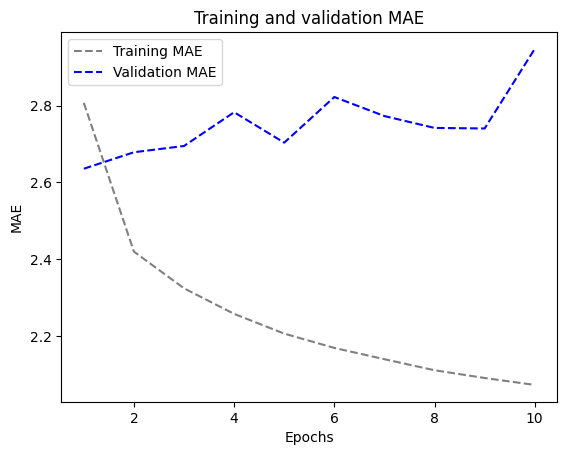

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


**Let's try a 1D convolutional model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 11s 10ms/step - loss: 21.0942 - mae: 3.6123 - val_loss: 16.8172 - val_mae: 3.2886
Epoch 2/10
819/819 [==============================] - 8s 9ms/step - loss: 14.9691 - mae: 3.0614 - val_loss: 13.9501 - val_mae: 2.9382
Epoch 3/10
819/819 [==============================] - 8s 9ms/step - loss: 13.5621 - mae: 2.9150 - val_loss: 14.0755 - val_mae: 2.9685
Epoch 4/10
819/819 [==============================] - 8s 9ms/step - loss: 12.6331 - mae: 2.8149 - val_loss: 14.4672 - val_mae: 3.0114
Epoch 5/10
819/819 [==============================] - 8s 9ms/step - loss: 11.9604 - mae: 2.7377 - val_loss: 15.6301 - val_mae: 3.1414
Epoch 6/10
819/819 [==============================] - 8s 9ms/step - loss: 11.4478 - mae: 2.6768 - val_loss: 14.6601 - val_mae: 3.0354
Epoch 7/10
819/819 [==============================] - 8s 9ms/step - loss: 11.0676 - mae: 2.6297 - val_loss: 16.7710 - val_mae: 3.2402
Epoch 8/10
819/819 [==============================] - 7s 9ms

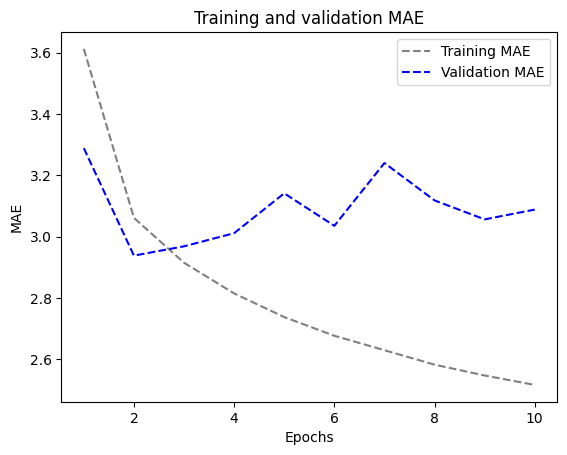

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

The underperformance of convolutional data in comparison to common sense or dense models may be attributed to several factors. Firstly, the assumption of translation invariance, which convolutional models rely on, may not be well-suited for weather data due to the intricate spatial and temporal dependencies inherent in such data.

Secondly, the temporal sequence of the data plays a pivotal role in weather forecasting. Recent historical data tends to carry more weight and relevance for predicting the temperature of the following day compared to data from further back in time. Unfortunately, 1D convolutional neural networks may struggle to effectively capture this crucial temporal order, thereby limiting their ability to accurately forecast future temperatures.

**A Simple RNN**

1.An RNN layer that can process sequences of any length

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 44s 52ms/step - loss: 138.7034 - mae: 9.6905 - val_loss: 144.0125 - val_mae: 9.9039
Epoch 2/10
819/819 [==============================] - 43s 52ms/step - loss: 136.4812 - mae: 9.5682 - val_loss: 143.7491 - val_mae: 9.8731
Epoch 3/10
819/819 [==============================] - 43s 52ms/step - loss: 136.2917 - mae: 9.5518 - val_loss: 143.6889 - val_mae: 9.8710
Epoch 4/10
819/819 [==============================] - 43s 52ms/step - loss: 136.2244 - mae: 9.5474 - val_loss: 143.6834 - val_mae: 9.8697
Epoch 5/10
819/819 [==============================] - 43s 52ms/step - loss: 136.1824 - mae: 9.5427 - val_loss: 143.5787 - val_mae: 9.8569
Epoch 6/10
819/819 [==============================] - 43s 52ms/step - loss: 136.1537 - mae: 9.5394 - val_loss: 143.5298 - val_mae: 9.8489
Epoch 7/10
819/819 [==============================] - 43s 52ms/step - loss: 136.1329 - mae: 9.5363 - val_loss: 143.5349 - val_mae: 9.8505
Epoch 8/10
819/819 [==============

**2. Simple RNN ** - Stacking RNN layers

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 180s 217ms/step - loss: 136.7445 - mae: 9.5590 - val_loss: 143.4461 - val_mae: 9.8415
Epoch 2/10
819/819 [==============================] - 178s 217ms/step - loss: 135.9363 - mae: 9.5096 - val_loss: 143.4065 - val_mae: 9.8353
Epoch 3/10
819/819 [==============================] - 178s 217ms/step - loss: 135.8863 - mae: 9.5042 - val_loss: 143.3776 - val_mae: 9.8305
Epoch 4/10
819/819 [==============================] - 177s 216ms/step - loss: 135.8618 - mae: 9.5010 - val_loss: 143.3766 - val_mae: 9.8316
Epoch 5/10
819/819 [==============================] - 176s 215ms/step - loss: 135.8491 - mae: 9.4994 - val_loss: 143.3662 - val_mae: 9.8317
Epoch 6/10
819/819 [==============================] - 177s 216ms/step - loss: 135.8424 - mae: 9.4981 - val_loss: 143.4732 - val_mae: 9.8429
Epoch 7/10
819/819 [==============================] - 178s 217ms/step - loss: 135.8261 - mae: 9.4952 - val_loss: 143.3780 - val_mae: 9.8307
Epoch 8/10
819/819 [

A Simple GRU (Gated Recurrent Unit)

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 12s 13ms/step - loss: 39.1433 - mae: 4.5341 - val_loss: 12.2428 - val_mae: 2.6362
Epoch 2/10
819/819 [==============================] - 10s 12ms/step - loss: 10.6237 - mae: 2.5341 - val_loss: 10.3376 - val_mae: 2.4548
Epoch 3/10
819/819 [==============================] - 10s 13ms/step - loss: 9.6906 - mae: 2.4277 - val_loss: 10.3251 - val_mae: 2.4413
Epoch 4/10
819/819 [==============================] - 10s 12ms/step - loss: 9.2517 - mae: 2.3706 - val_loss: 9.8828 - val_mae: 2.4048
Epoch 5/10
819/819 [==============================] - 11s 13ms/step - loss: 9.0078 - mae: 2.3399 - val_loss: 11.6202 - val_mae: 2.5623
Epoch 6/10
819/819 [==============================] - 10s 12ms/step - loss: 8.8325 - mae: 2.3184 - val_loss: 11.1569 - val_mae: 2.5215
Epoch 7/10
819/819 [==============================] - 10s 12ms/step - loss: 8.6647 - mae: 2.2974 - val_loss: 10.5298 - val_mae: 2.4652
Epoch 8/10
819/819 [==============================] - 

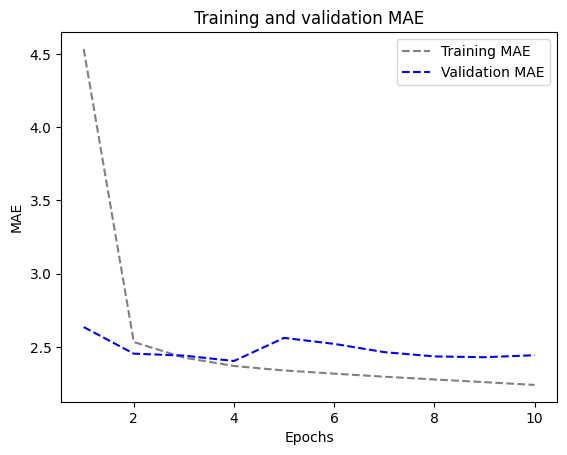

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**LSTM(Long Short-Term Memory )**

1.LSTM-Simple

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 12s 13ms/step - loss: 50.9579 - mae: 5.2312 - val_loss: 14.4775 - val_mae: 2.8805
Epoch 2/10
819/819 [==============================] - 10s 12ms/step - loss: 11.8947 - mae: 2.6735 - val_loss: 9.8636 - val_mae: 2.4442
Epoch 3/10
819/819 [==============================] - 10s 12ms/step - loss: 10.1388 - mae: 2.4899 - val_loss: 9.9023 - val_mae: 2.4537
Epoch 4/10
819/819 [==============================] - 10s 12ms/step - loss: 9.7605 - mae: 2.4415 - val_loss: 9.9861 - val_mae: 2.4529
Epoch 5/10
819/819 [==============================] - 10s 12ms/step - loss: 9.5367 - mae: 2.4120 - val_loss: 10.0746 - val_mae: 2.4621
Epoch 6/10
819/819 [==============================] - 10s 12ms/step - loss: 9.3699 - mae: 2.3884 - val_loss: 9.5810 - val_mae: 2.4185
Epoch 7/10
819/819 [==============================] - 10s 12ms/step - loss: 9.2043 - mae: 2.3661 - val_loss: 10.0410 - val_mae: 2.4645
Epoch 8/10
819/819 [==============================] - 10

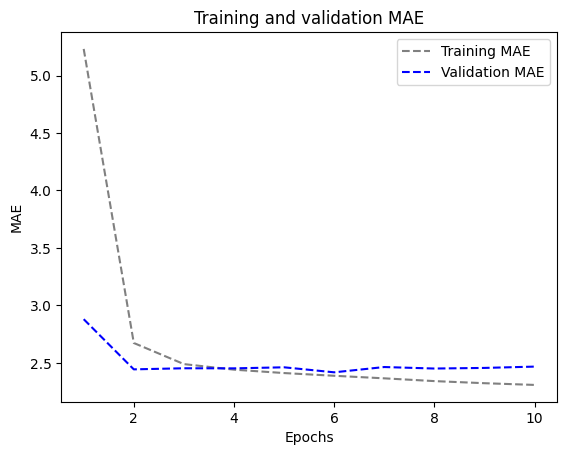

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**2.LSTM - dropout Regularization**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 197s 237ms/step - loss: 48.8952 - mae: 5.2199 - val_loss: 13.5809 - val_mae: 2.7758
Epoch 2/10
819/819 [==============================] - 193s 236ms/step - loss: 20.1227 - mae: 3.4429 - val_loss: 10.0013 - val_mae: 2.4544
Epoch 3/10
819/819 [==============================] - 194s 236ms/step - loss: 18.4846 - mae: 3.3087 - val_loss: 9.5677 - val_mae: 2.4143
Epoch 4/10
819/819 [==============================] - 194s 237ms/step - loss: 17.6151 - mae: 3.2341 - val_loss: 9.4199 - val_mae: 2.4046
Epoch 5/10
819/819 [==============================] - 193s 236ms/step - loss: 16.8861 - mae: 3.1609 - val_loss: 9.5994 - val_mae: 2.4239
Epoch 6/10
819/819 [==============================] - 194s 237ms/step - loss: 16.2658 - mae: 3.1085 - val_loss: 9.4460 - val_mae: 2.4060
Epoch 7/10
819/819 [==============================] - 195s 238ms/step - loss: 15.9770 - mae: 3.0823 - val_loss: 9.5219 - val_mae: 2.4168
Epoch 8/10
819/819 [===================

405/405 [==============================] - 18s 42ms/step - loss: 10.6209 - mae: 2.5535
Test MAE: 2.55


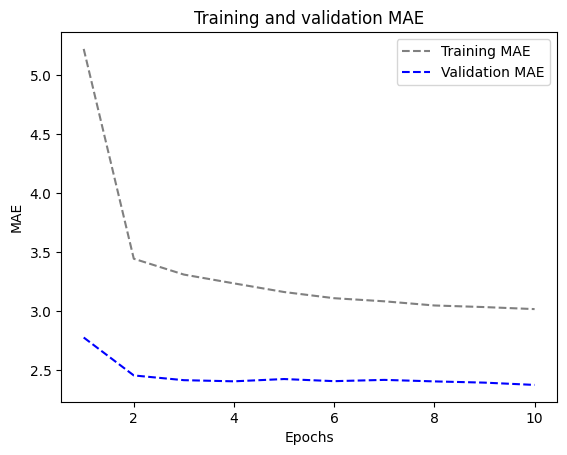

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**3.LSTM - Stacked setup with 16 units**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 18s 19ms/step - loss: 40.1966 - mae: 4.6167 - val_loss: 13.0310 - val_mae: 2.7484
Epoch 2/10
819/819 [==============================] - 15s 18ms/step - loss: 10.5293 - mae: 2.5139 - val_loss: 9.8857 - val_mae: 2.4516
Epoch 3/10
819/819 [==============================] - 15s 18ms/step - loss: 9.0903 - mae: 2.3477 - val_loss: 10.0693 - val_mae: 2.4955
Epoch 4/10
819/819 [==============================] - 15s 18ms/step - loss: 8.4700 - mae: 2.2726 - val_loss: 10.9650 - val_mae: 2.5548
Epoch 5/10
819/819 [==============================] - 15s 18ms/step - loss: 8.0475 - mae: 2.2133 - val_loss: 10.3368 - val_mae: 2.5230
Epoch 6/10
819/819 [==============================] - 15s 18ms/step - loss: 7.5272 - mae: 2.1405 - val_loss: 11.2044 - val_mae: 2.6214
Epoch 7/10
819/819 [==============================] - 15s 18ms/step - loss: 7.1883 - mae: 2.0952 - val_loss: 11.9380 - val_mae: 2.6977
Epoch 8/10
819/819 [==============================] - 

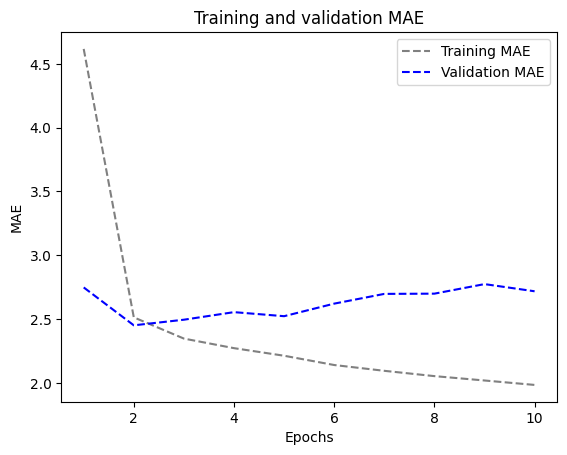

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**4.LSTM - Stacked setup with 32 units**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 19s 19ms/step - loss: 20.9205 - mae: 3.2809 - val_loss: 10.2356 - val_mae: 2.5111
Epoch 2/10
819/819 [==============================] - 15s 18ms/step - loss: 8.0107 - mae: 2.2051 - val_loss: 10.5049 - val_mae: 2.5516
Epoch 3/10
819/819 [==============================] - 15s 18ms/step - loss: 6.8123 - mae: 2.0294 - val_loss: 12.0589 - val_mae: 2.7595
Epoch 4/10
819/819 [==============================] - 15s 18ms/step - loss: 5.8637 - mae: 1.8777 - val_loss: 11.6224 - val_mae: 2.6894
Epoch 5/10
819/819 [==============================] - 15s 18ms/step - loss: 5.1231 - mae: 1.7515 - val_loss: 12.8782 - val_mae: 2.8209
Epoch 6/10
819/819 [==============================] - 15s 19ms/step - loss: 4.5089 - mae: 1.6446 - val_loss: 12.9797 - val_mae: 2.8429
Epoch 7/10
819/819 [==============================] - 15s 18ms/step - loss: 4.0502 - mae: 1.5605 - val_loss: 12.8618 - val_mae: 2.8205
Epoch 8/10
819/819 [==============================] - 

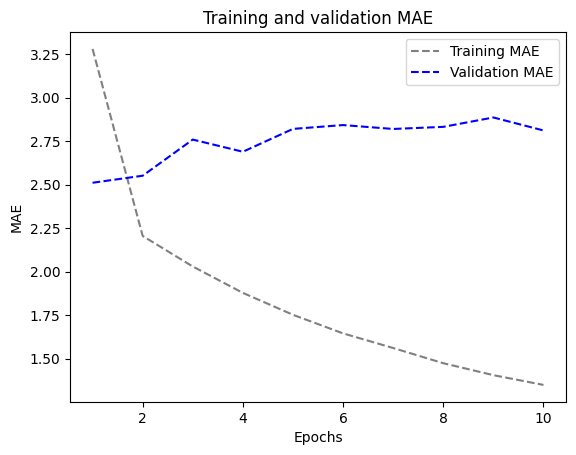

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**4.LSTM - Stacked setup with 8 units**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 18s 19ms/step - loss: 68.0561 - mae: 6.2895 - val_loss: 33.5183 - val_mae: 4.2936
Epoch 2/10
819/819 [==============================] - 15s 18ms/step - loss: 20.2713 - mae: 3.3199 - val_loss: 12.7753 - val_mae: 2.7000
Epoch 3/10
819/819 [==============================] - 15s 18ms/step - loss: 11.0020 - mae: 2.5569 - val_loss: 9.9135 - val_mae: 2.4428
Epoch 4/10
819/819 [==============================] - 15s 18ms/step - loss: 9.7609 - mae: 2.4251 - val_loss: 9.7786 - val_mae: 2.4423
Epoch 5/10
819/819 [==============================] - 15s 18ms/step - loss: 9.3801 - mae: 2.3772 - val_loss: 9.6501 - val_mae: 2.4217
Epoch 6/10
819/819 [==============================] - 15s 18ms/step - loss: 9.1519 - mae: 2.3493 - val_loss: 9.4909 - val_mae: 2.3966
Epoch 7/10
819/819 [==============================] - 15s 18ms/step - loss: 8.9925 - mae: 2.3280 - val_loss: 9.5845 - val_mae: 2.4235
Epoch 8/10
819/819 [==============================] - 15s

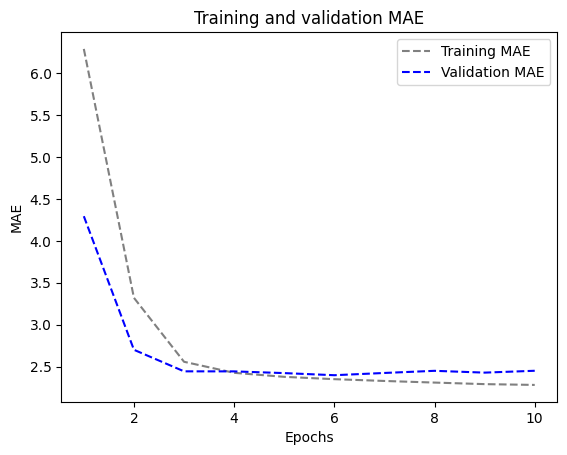

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**5.LSTM - dropout-regularized, stacked model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 422s 510ms/step - loss: 73.1853 - mae: 6.5735 - val_loss: 35.0726 - val_mae: 4.4013
Epoch 2/10
819/819 [==============================] - 417s 509ms/step - loss: 31.5558 - mae: 4.1926 - val_loss: 14.2112 - val_mae: 2.8209
Epoch 3/10
819/819 [==============================] - 417s 510ms/step - loss: 24.2780 - mae: 3.7267 - val_loss: 11.3160 - val_mae: 2.5835
Epoch 4/10
819/819 [==============================] - 418s 510ms/step - loss: 22.2863 - mae: 3.5821 - val_loss: 10.4509 - val_mae: 2.4978
Epoch 5/10
819/819 [==============================] - 416s 508ms/step - loss: 21.1156 - mae: 3.4879 - val_loss: 10.1050 - val_mae: 2.4640
Epoch 6/10
819/819 [==============================] - 416s 508ms/step - loss: 20.1423 - mae: 3.4115 - val_loss: 9.6339 - val_mae: 2.4138
Epoch 7/10
819/819 [==============================] - 417s 509ms/step - loss: 19.3113 - mae: 3.3435 - val_loss: 9.5150 - val_mae: 2.3981
Epoch 8/10
819/819 [================

405/405 [==============================] - 33s 80ms/step - loss: 10.6964 - mae: 2.5360
Test MAE: 2.54


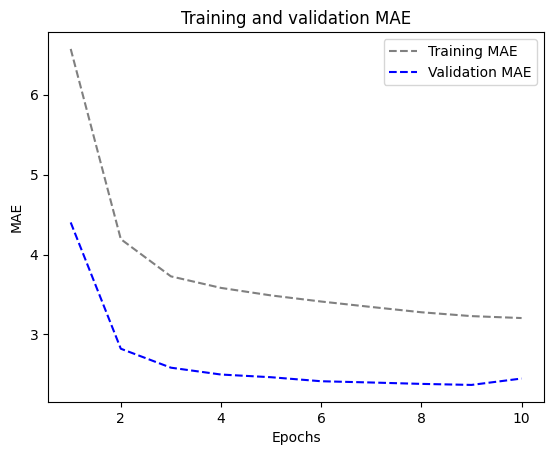

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**Bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 18s 19ms/step - loss: 27.6660 - mae: 3.7533 - val_loss: 10.5897 - val_mae: 2.5275
Epoch 2/10
819/819 [==============================] - 15s 18ms/step - loss: 9.3872 - mae: 2.3861 - val_loss: 10.0266 - val_mae: 2.4625
Epoch 3/10
819/819 [==============================] - 15s 18ms/step - loss: 8.4400 - mae: 2.2528 - val_loss: 10.0078 - val_mae: 2.4503
Epoch 4/10
819/819 [==============================] - 15s 18ms/step - loss: 7.8822 - mae: 2.1771 - val_loss: 10.2793 - val_mae: 2.4747
Epoch 5/10
819/819 [==============================] - 15s 18ms/step - loss: 7.4340 - mae: 2.1187 - val_loss: 10.5209 - val_mae: 2.5013
Epoch 6/10
819/819 [==============================] - 15s 18ms/step - loss: 7.0668 - mae: 2.0675 - val_loss: 10.5445 - val_mae: 2.5100
Epoch 7/10
819/819 [==============================] - 15s 19ms/step - loss: 6.7604 - mae: 2.0236 - val_loss: 10.9992 - val_mae: 2.5449
Epoch 8/10
819/819 [==============================] - 

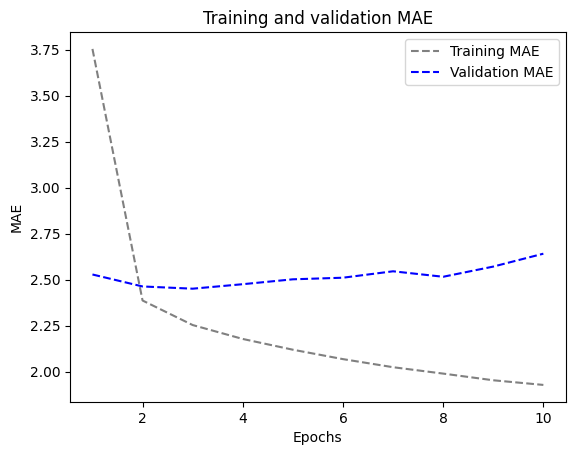

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**1D Convnets and LSTM togther**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 11s 10ms/step - loss: 49.7674 - mae: 5.2855 - val_loss: 26.6913 - val_mae: 3.9922
Epoch 2/10
819/819 [==============================] - 8s 10ms/step - loss: 17.7952 - mae: 3.2500 - val_loss: 21.8648 - val_mae: 3.7244
Epoch 3/10
819/819 [==============================] - 8s 10ms/step - loss: 14.3501 - mae: 2.9364 - val_loss: 24.2744 - val_mae: 3.8384
Epoch 4/10
819/819 [==============================] - 8s 10ms/step - loss: 12.8525 - mae: 2.7737 - val_loss: 21.2613 - val_mae: 3.6724
Epoch 5/10
819/819 [==============================] - 8s 10ms/step - loss: 11.7863 - mae: 2.6525 - val_loss: 21.4942 - val_mae: 3.6941
Epoch 6/10
819/819 [==============================] - 8s 10ms/step - loss: 10.9668 - mae: 2.5559 - val_loss: 23.5697 - val_mae: 3.8202
Epoch 7/10
819/819 [==============================] - 9s 11ms/step - loss: 10.3016 - mae: 2.4709 - val_loss: 23.4867 - val_mae: 3.8163
Epoch 8/10
819/819 [==============================] - 

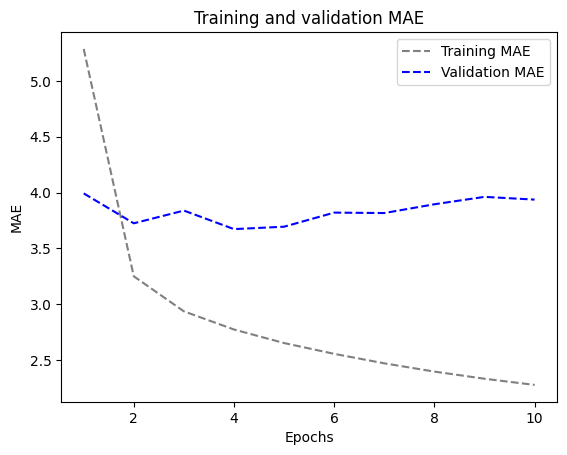

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

We built 14 models: Following are the details;

Model 1: common-sense, non-machine-learning baseline

Model 2: A basic machine-learning model

Model 3: 1D convolutional model

Model 4: Simple RNN layer that can process sequences of any length

Model 5: Simple RNN - Stacking RNN layers

Model 6: A Simple GRU (Gated Recurrent Unit)

Model 7: LSTM-Simple

Model 8: LSTM - dropout Regularization

Model 9: Stacked setup with 16 units

Model 10: Stacked setup with 32 units

Model 11: Stacked setup with 8 units

Model 12: LSTM - dropout-regularized, stacked

Model 13: Bidirectional LSTM

Model 14: 1D Convnets and LSTM togther

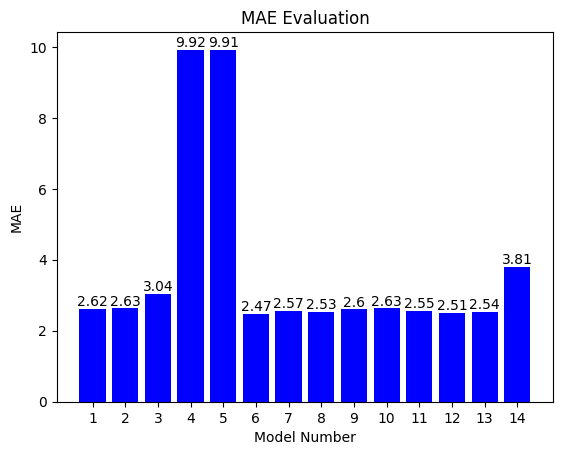

In [ ]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.63,3.04,9.92,9.91,2.47,2.57,2.53,2.60,2.63,2.55,2.51,2.54,3.81)

# MAE Evaluation
plt.bar(Models, Mae, color="blue")

plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()